# Image Denoising Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a denoising model. For a given noisy image $X$, our model should learn to predict the denoised image $y$.


**Objectives**
- Visualize images
- Preprocess images for the neural network
- Fit a custom CNN for the task

## 1. Load Data

👉 Let's download the dataset archive.
It contains RGB and Black & White images we will be using for the rest of this challenge.

In [1]:
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/paintings.zip > paintings.zip
! unzip -nq "paintings.zip" 
! rm "paintings.zip"
! ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 90.1M  100 90.1M    0     0  2456k      0  0:00:37  0:00:37 --:--:-- 1635k 0:00:23  0:00:12 2730k
total 1008
-rw-r--r--     1 work  staff       0 Jun 29 09:17 README.md
-rw-r--r--@    1 work  staff  513348 Jun 30 16:11 image_denoising.ipynb
drwx------  1087 work  staff   34784 Jun  9 15:06 paintings
drwxr-xr-x     4 work  staff     128 Jun 30 14:53 tests


In [12]:
import glob
from PIL.Image import open
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from tensorflow.image import resize

In [2]:
dataset_paths = glob.glob("./paintings/*.jpg")
dataset_paths

['./paintings/Joan_Miro_48.jpg',
 './paintings/Titian_232.jpg',
 './paintings/Amedeo_Modigliani_30.jpg',
 './paintings/Frida_Kahlo_21.jpg',
 './paintings/Marc_Chagall_59.jpg',
 './paintings/Salvador_Dali_116.jpg',
 './paintings/Vincent_van_Gogh_363.jpg',
 './paintings/Paul_Klee_47.jpg',
 './paintings/Kazimir_Malevich_106.jpg',
 './paintings/Leonardo_da_Vinci_7.jpg',
 './paintings/Francisco_Goya_199.jpg',
 './paintings/Vincent_van_Gogh_161.jpg',
 './paintings/Paul_Klee_90.jpg',
 './paintings/Paul_Cezanne_24.jpg',
 './paintings/Peter_Paul_Rubens_42.jpg',
 './paintings/Amedeo_Modigliani_184.jpg',
 './paintings/Titian_52.jpg',
 './paintings/Alfred_Sisley_165.jpg',
 './paintings/Paul_Gauguin_72.jpg',
 './paintings/Vincent_van_Gogh_767.jpg',
 './paintings/Raphael_106.jpg',
 './paintings/Pablo_Picasso_78.jpg',
 './paintings/Diego_Rivera_10.jpg',
 './paintings/Pieter_Bruegel_108.jpg',
 './paintings/Hieronymus_Bosch_25.jpg',
 './paintings/Joan_Miro_6.jpg',
 './paintings/Kazimir_Malevich_79.jpg'

❓ **Display the image at index `53` of this dataset_paths (i.e the 54-th image)**

<details>
    <summary>Hint</summary>
    Use the <code>PIL.Image.open</code> and <code>matplotlib.pyplot.imshow</code> functions.
</details>

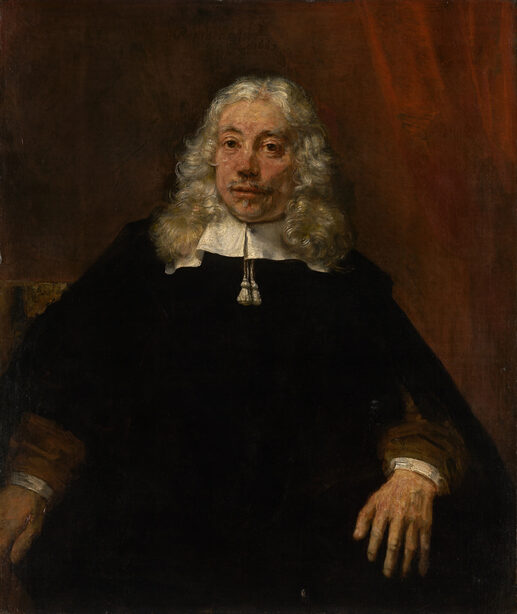

In [3]:
# YOUR CODE HERE
open(dataset_paths[53])

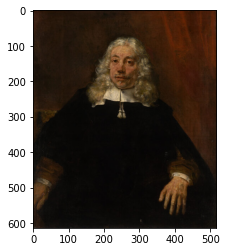

In [4]:
image = img.imread(dataset_paths[53])
plt.imshow(image)

❓ **What is the shape of the image you displayed above `img_shape`?  How many dimensions `img_dim` does it have ?**

In [5]:
# YOUR CODE HERE
img_shape = image.shape
img_shape

(614, 517, 3)

In [6]:
img_dim = image.ndim
img_dim

3

❓ **What was in the image above?**

In [7]:
img_shape = img_shape
img_dim = img_dim

# Uncomment the correct answer

is_portrait = True
#is_portrait = False

is_colored_image = True
#is_colored_image = False

In [8]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    img_shape=img_shape,
    img_dim=img_dim,
    is_portrait=is_portrait,
    is_colored_image=is_colored_image
)

result.write()

## 2. Processing

❓ **Store all images from the dataset folder in a list of numpy arrays called `dataset_images`**

- It can take a while
- If the dataset is too big to fit in memory, just take the first half (or quarter) of all pictures

In [9]:
# YOUR CODE HERE
dataset_images = []
length = int(len(dataset_paths)/4)
for path in dataset_paths[:length]:
    dataset_images.append(img.imread(path))


### 2.1 Reshape, Resize, Rescale

Let's simplify our dataset and convert it to a single numpy array

❓ **First, check if that all the images in the dataset have the same number of dimensions**.
- What do you notice?
- How do you explain it? 

In [10]:
# YOUR CODE HERE
image_same_dimension = True
for image in dataset_images:
    if image.ndim != 3 :
        image_same_dimension = False
        break

image_same_dimension

False

> No all images in the dataset have not  the same number of dimensions. Means some images is in back and white

👉 We convert for you all black & white images into 3-colored ones by duplicating the image on three channels, so as to have only 3D arrays

In [13]:
dataset_images = [x if x.ndim==3 else np.repeat(x[:,:,None], 3, axis=2) for x in dataset_images]
set([x.ndim for x in dataset_images])

{3}

❓ **What about their shape now ?**
- Do they all have the same width/heights ? If not:
- Resize the images (120 pixels height and 100 pixels width) in the dataset, using `tensorflow.image.resize` function.
- Now that they all have the same shape, store them as a numpy array `dataset_resized`.
- This array should thus be of size $(n_{images}, 120, 100, 3)$

In [14]:
# YOUR CODE HERE
image_same_shape= True
shape = dataset_images[0].shape
for image in dataset_images:
    if image.shape != shape :
        image_same_shape = False
        break

image_same_shape

False

> No all image have not  the same shape, so we need to resize

In [24]:
dataset_resized = []
for image in dataset_images:
    dataset_resized.append(resize(image,[120,100]))

In [26]:
len(dataset_resized)

271

❓ **Rescale the data of each image between $0$ and $1$**
- Save your resulting list as `dataset_scaled`

In [27]:
# YOUR CODE HERE
dataset_scaled = [image/255 for image in dataset_resized]

In [30]:
dataset_scaled = np.array(dataset_scaled)

### 2.2 Create (X,y) sets

👉 Now, we'll add for you some **random noise** to our images to simulate noise (that our model will try to remove later)

In [31]:
NOISE_LEVEL = 0.2

dataset_noisy = np.clip(
    dataset_scaled + np.random.normal(
        loc=0,
        scale=NOISE_LEVEL,
        size=dataset_scaled.shape
    ).astype(np.float32),
    0,
    1
)
dataset_noisy.shape

(271, 120, 100, 3)

❓ **Plot a noisy image below to visualize the noise and compare it with the normal one**

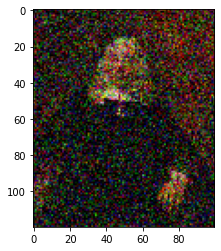

In [42]:
# YOUR CODE HERE
plt.imshow(dataset_noisy[53])

❓ **Create your `(X_train, Y_train)`, `(X_test, Y_test)` training set for your problem**

- Remember you are trying to use "noisy" pictures in order to predict the "normal" ones.
- Keeping about `20%` of randomly sampled data as test set

In [43]:
# YOUR CODE HERE
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(dataset_noisy,dataset_scaled,test_size=0.2)

In [44]:
from nbresult import ChallengeResult
result = ChallengeResult(
    "preprocessing",
    X_train_shape = X_train.shape,
    Y_train_shape = Y_train.shape,
    X_std = X_train[:,:,:,0].std(),
    Y_std = Y_train[:,:,:,0].std(),
    first_image = Y_train[0]
)
result.write()

## 3. Convolutional Neural Network

A commonly used neural network architecture for image denoising is the __AutoEncoder__.

<img src='https://github.com/lewagon/data-images/blob/master/DL/autoencoder.png?raw=true'>

Its goal is to learn a compact representation of your data to reconstruct them as precisely as possible.  
The loss for such model must incentivize it to have __an output as close to the input as possible__.

For this challenge, __you will only be asked to code the Encoder part of the network__, since building a Decoder leverages layers architectures you are not familiar with (yet).

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_painting_solution.pickle > data_painting_solution.pickle

import pickle
with open("data_painting_solution.pickle", "rb") as file:
    (X_train, Y_train, X_test, Y_test) = pickle.load(file)
    
! rm data_painting_solution.pickle
```

### 3.1 Architecture

👉 Run the cell below that defines the decoder

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Sequential

In [47]:
30*25*8

6000

In [46]:
# We choose to compress images into a latent_dimension of size 6000
latent_dimensions = 6000

# We build a decoder that takes 1D-vectors of size 6000 to reconstruct images of shape (120,100,3)
decoder = Sequential(name='decoder')
decoder.add(layers.Reshape((30, 25, 8), input_dim=latent_dimensions))
decoder.add(layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2D(filters=3, kernel_size=3, padding="same", activation="sigmoid"))
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 25, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 60, 50, 16)        1168      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 120, 100, 32)      4640      
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 100, 3)       867       
Total params: 6,675
Trainable params: 6,675
Non-trainable params: 0
_________________________________________________________________


❓ **Now, build the `encoder` that plugs correctly with the decoder defined above**. Make sure that:
- The output of your `encoder` is the same shape as the input of the `decoder`
- Use a convolutional neural network architecture without transfer learning
- Keep it simple
- Print model summary

In [51]:
# CODE HERE YOUR ENCODER ARCHITECTURE AND PRINT IT'S MODEL SUMMARY
encoder = Sequential(name='encoder')
encoder.add(layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(120, 100, 3)))
encoder.add(layers.Conv2D(16, kernel_size=3, strides=2, padding="same", activation="relu"))
encoder.add(layers.Conv2D(8, kernel_size=3, strides=2, padding="same", activation="relu"))
encoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 118, 98, 32)       896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 49, 16)        4624      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 25, 8)         1160      
Total params: 6,680
Trainable params: 6,680
Non-trainable params: 0
_________________________________________________________________


👉 **Test your encoder below**

In [52]:
# HERE WE BUILD THE AUTO-ENCODER (ENCODER + DECODER) FOR YOU. IT SHOULD PRINT A NICE SUMMARY
from tensorflow.keras.models import Model

x = layers.Input(shape=(120, 100, 3))
autoencoder = Model(x, decoder(encoder(x)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 100, 3)]     0         
_________________________________________________________________
encoder (Sequential)         (None, 30, 25, 8)         6680      
_________________________________________________________________
decoder (Sequential)         (None, 120, 100, 3)       6675      
Total params: 13,355
Trainable params: 13,355
Non-trainable params: 0
_________________________________________________________________


### 3.2 Training

❓ **Before training the autoencoder, evaluate your baseline score**
- We will use the mean absolute error in this challenge
- Compute the baseline score on your test set in the "stupid" case where you don't manage to de-noise anything at all.
- Store the result under `score_baseline`

In [ ]:
# YOUR CODE HERE

❓ Now, **train your autoencoder**

- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 5 minutes of training without GPUs.

In [54]:
# YOUR CODE HERE
from tensorflow.keras import optimizers
adam_opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
autoencoder.compile(loss='binary_crossentropy', 
              optimizer=adam_opt,
              metrics=['mae'])

In [ ]:
from tensorflow.keras import callbacks

es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)
history = autoencoder.fit(X_train, Y_train,
              batch_size=16, # Too small --> no generalization. Too large --> compute slowly
              epochs=100,
              validation_split=0.3,
              callbacks=[es],
              verbose=2)

❓ **Plot your training and validation loss at each epoch using the cell below**

In [ ]:
# Plot below your train/val loss history
# YOUR CODE HERE
# YOUR CODE HERE
# YOUR CODE HERE


# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Evaluate your performances on test set**
- Compute your de-noised test set `Y_pred` 
- Store your test score as `score_test`
- Plot a de-noised image from your test set and compare it with the original and noisy one using the cell below

In [ ]:
# YOUR CODE HERE

NameError: name 'Y_pred' is not defined

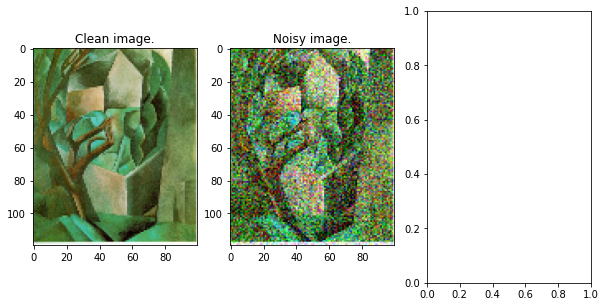

In [56]:
# RUN THIS CELL TO CHECK YOUR RESULTS
idx = 0

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(Y_test[idx])
axs[0].set_title("Clean image.")

axs[1].imshow(X_test[idx])
axs[1].set_title("Noisy image.")

axs[2].imshow(Y_pred[idx])
axs[2].set_title("Prediction.")

# Run this to save your results for correction
plt.savefig('tests/image_denoised.png')

🧪 **Send your results below**

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    input_shape = list(encoder.input.shape),
    output_shape = list(encoder.output.shape),
    layer_names = [layer.name for layer in encoder.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in encoder.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()